# Data Modeling 

### Summary:
The goal of this notebook is to begin the geographical modeling of the datasets collected to produce some solutions to the business questiion.  

Using Spatial Autocorrelation techniques, the data was analyzed and visualized for the following criteria:

* Signs per Square Kilometer (used to establish a baseline)
* Accidents per Sign Per Square Kilometer
* Accidents per Sign Per Square Kilometer in Above Average Population Count Tracts


In [1]:
import geopandas as gpd
import pysal as ps
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pysal.viz.mapclassify as mc  # <-- needed for Quantiles
from pysal.viz.splot import mapping as maps
from matplotlib import colors

%matplotlib inline

C:\Users\Mills\Anaconda3\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


### Demographic Dataset

In [2]:
# File paths
fp_dem = '../data/CleanDemographic/demproj.geojson'

# Note - the shp file truncated the column names when working in Sprint 1A.

In [3]:
# Create dataframe
gdf_demproj = gpd.read_file(fp_dem)

In [4]:
gdf_demproj.head()

spatial_id                    name  Total_Household_Count  \
0  5350001.00  CT0001.00, Toronto, ON                  249.0   
1  5350002.00  CT0002.00, Toronto, ON                  267.0   
2  5350003.00  CT0003.00, Toronto, ON                  537.0   
3  5350004.00  CT0004.00, Toronto, ON                 3712.0   
4  5350005.00  CT0005.00, Toronto, ON                 3722.0   

   Total_Population_Count  Total_Income_Over_100K_Count  \
0                   600.0                          88.0   
1                   613.0                          74.0   
2                  1557.0                         219.0   
3                  7177.0                         342.0   
4                  6969.0                         445.0   

   Total_Income_Over_250K_Count  Avg_Household_Income_Dollars  \
0                          15.0                     120561.50   
1                           7.0                      75392.63   
2                          28.0                     120833.84   
3                         121.0                      54432.35   
4                         127.0                      65003.69   

   Median_Household_Income_Dollars  \
0                         79727.91   
1                         74505.79   
2                         88073.28   
3                         27670.45   
4                         33807.26   

   Total_Population_Languages_No_Eng_French_Count  \
0                                            22.0   
1                                             0.0   
2                                            17.0   
3                                           392.0   
4                                           301.0   

   Total_Houshold_Mother_Tongue_Eng_Pct  ...  Above_Avg_Population_Count  \
0                               72.5000  ...                           0   
1                               89.1566  ...                           0   
2                               53.8462  ...                           0   
3                               50.0513  ...                           1   
4                               55.8916  ...                           1   

   Above_Avg_Over_100K_Count  Above_Avg_Over_250K_Count  \
0                          0                          0   
1                          0                          0   
2                          0                          0   
3                          0                          0   
4                          0                          0   

   Above_Avg_Pop_No_Eng_Fr_Count  Above_Avg_Pop_Eng_First_Count  \
0                              0                              1   
1                              0                              1   
2                              0                              1   
3                              1                              0   
4                              1                              1   

   Above_Avg_Consumption_Dollars  Above_Avg_Expenditure_Dollars  \
0                              0                              0   
1                              0                              0   
2                              0                              0   
3                              0                              0   
4                              1                              0   

   Above_Med_AvgHousehold_Income_Dollars  \
0                                      1   
1                                      0   
2                                      1   
3                                      0   
4                                      0   

   Above_Med_MedHousehold_Income_Dollars  \
0                                      1   
1                                      1   
2                                      1   
3                                      0   
4                                      0   

                                            geometry  
0  POLYGON ((320680.3743114723 4835111.663189559,...  
1  POLYGON ((317005.3262185335 4832246.620448819,...  
2  POLYGON 

In [5]:
gdf_demproj.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 572 entries, 0 to 571
Data columns (total 28 columns):
spatial_id                                        572 non-null object
name                                              572 non-null object
Total_Household_Count                             572 non-null float64
Total_Population_Count                            572 non-null float64
Total_Income_Over_100K_Count                      572 non-null float64
Total_Income_Over_250K_Count                      572 non-null float64
Avg_Household_Income_Dollars                      572 non-null float64
Median_Household_Income_Dollars                   572 non-null float64
Total_Population_Languages_No_Eng_French_Count    572 non-null float64
Total_Houshold_Mother_Tongue_Eng_Pct              572 non-null float64
Total_Current_Consumption_Dollars                 572 non-null float64
Total_Expenditure_Dollars                         572 non-null float64
Area                                 

#### NOTE:
Using this tutorial as a reference:  http://darribas.org/gds_scipy16/ipynb_md/04_esda.html
    
An attempt will be made to use Exploratory Spatial Data Analysis as a took to examine the similarities between tracts in Toronto as they relate to third-party signs and traffic accidents.    

## I.  Spatial Autocorrelation - Signs per Square Km

C:\Users\Mills\Anaconda3\lib\site-packages\pysal\viz\mapclassify\classifiers.py:95: UserWarning: Warning: Not enough unique values in array to form k classes
  UserWarning)
C:\Users\Mills\Anaconda3\lib\site-packages\pysal\viz\mapclassify\classifiers.py:96: UserWarning: Warning: setting k to 7
  Warn('Warning: setting k to %d' % k_q, UserWarning)


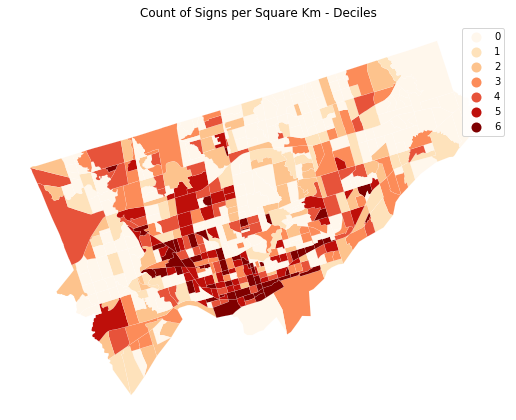

In [6]:
# Visualize the Deciles of sign locations
signs10 = mc.Quantiles(gdf_demproj['Signs_Per_Square_Km'], k=10)

f, ax = plt.subplots(1, figsize=(9,9))
gdf_demproj.assign(cl=signs10.yb).plot(column='cl', categorical=True, \
                                      k=10, cmap='OrRd', linewidth=0.1, ax=ax, \
                                      edgecolor='white', legend=True)
ax.set_axis_off()
plt.title('Count of Signs per Square Km - Deciles')
plt.show()

#### NOTE:
In the above, similar regions (by colour) are found in the south and central tracts.  Lighter areas in the east and north also appear to be related.

### Spatial Similarity
As noted in the tutorial, the use of spatial weights "formalize the notion of spatial similarity".  It is used to determine how geographically similar a region is with another.

In [7]:
# Use queen contiguity to apply weights
W = ps.lib.weights.Queen.from_dataframe(gdf_demproj)

# Standardize the rows so all values range from 0 to 1, and the row sum is 1
W.transform = 'r'


In [8]:
print(W)

### Attribute Similarity
Spatial lag is used to measure how similar the attributes are between regions.  To begin, the Signs per Square Km attribute will be measured.

In [9]:
signs10Lag = ps.lib.weights.lag_spatial(W, gdf_demproj['Signs_Per_Square_Km'])

In [10]:
signs10LagQ10 = mc.Quantiles(signs10Lag, k=10)

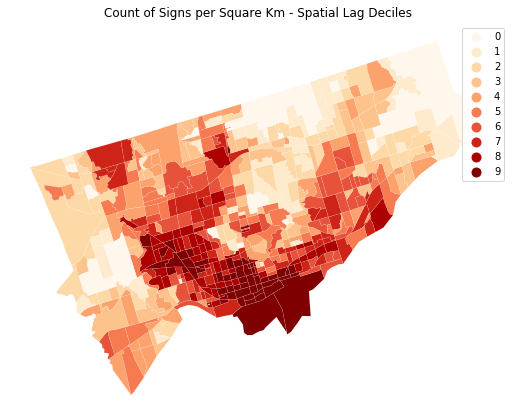

In [11]:
f, ax = plt.subplots(1, figsize=(9,9))

gdf_demproj.assign(cl=signs10LagQ10.yb).plot(column='cl', categorical=True, \
                                      k=10, cmap='OrRd', linewidth=0.1, ax=ax, \
                                      edgecolor='white', legend=True)
ax.set_axis_off()
plt.title('Count of Signs per Square Km - Spatial Lag Deciles')
plt.show()

#### NOTE:
The above reveals greater similarity amongst the tracts in the south-central tracts and the north-eastern tracts.  How does this translate into statistical measures?

In [12]:
signs = gdf_demproj['Signs_Per_Square_Km']
b, a = np.polyfit(signs, signs10Lag, 1)

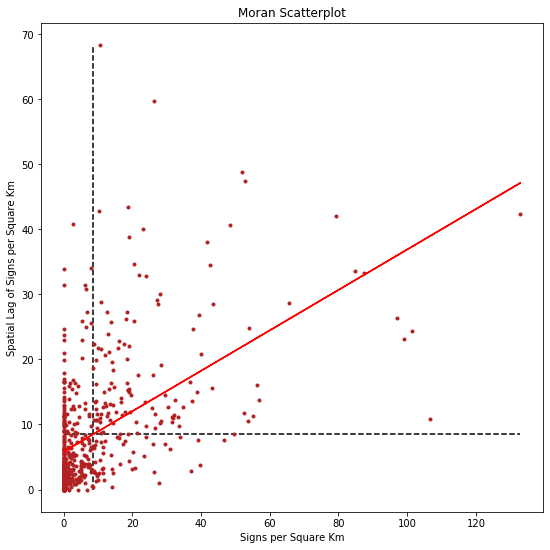

In [13]:
f, ax = plt.subplots(1, figsize=(9,9))

plt.plot(signs, signs10Lag, '.', color='firebrick')

# dashed vert at mean of the average signs per square Km
plt.vlines(signs.mean(), signs10Lag.min(), signs10Lag.max(), linestyle='--')

# dashed horizontal at mean of lagged the average signs per square Km
plt.hlines(signs10Lag.mean(), signs.min(), signs.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(signs, a+b*signs, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Signs per Square Km')
plt.xlabel('Signs per Square Km')
plt.show()

### Global Spatial Autocorrelation
Compute Moran's $I$ statistic to examine the spatial dependence in the Signs per Square Km:

In [14]:
I_signs = ps.explore.esda.Moran(gdf_demproj['Signs_Per_Square_Km'].values, W)

In [15]:
print('The I statistic is ', I_signs.I)
print('The slope of the line is ', b)
print('The p value is ', I_signs.p_sim)

The I statistic is  0.3105542927736304
The slope of the line is  0.3105542927736305
The p value is  0.001


Using the stored collection of simulated $I$ statistics, visualize the results:

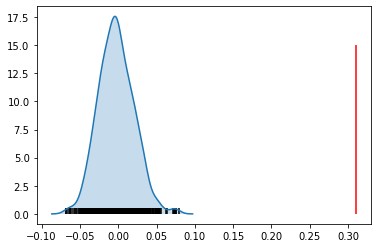

In [16]:
sns.kdeplot(I_signs.sim, shade=True)
plt.vlines(I_signs.sim, 0, 0.5)
plt.vlines(I_signs.I, 0, 15, 'r')

What if the $I$ statistic were close to the expected value of $I$?

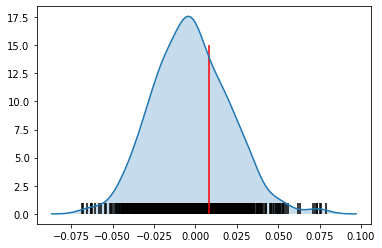

In [17]:
sns.kdeplot(I_signs.sim, shade=True)
plt.vlines(I_signs.sim, 0, 1)
plt.vlines(I_signs.EI+0.01, 0, 15, 'r')


#### NOTE:
Based on a Moran's $I$ value of 0.31, we can conclude that there is some clustering of similar values (ie. $I$ is a positive value), but the values are somewhat close to being random in nature (ie. $I$ is close to 0).  The $p$-value of 0.001 indicates that this $I$ value was not generated by chance.

Interpretation of $I$ was found on this site:  https://www.statisticshowto.datasciencecentral.com/morans-i/

### Local Autocorrelation Statistics


In [18]:
LMo_signs = ps.explore.esda.Moran_Local(gdf_demproj['Signs_Per_Square_Km'].values, W)

In [19]:
# Check the array of I statistics and p-values
LMo_signs.Is[0:10], LMo_signs.p_sim[0:10]

(array([-1.45067445e-01, -8.66595729e-01,  1.51374208e-04, -2.06040020e-01,
         5.94877486e-02,  2.96323964e-01, -2.16310324e-01,  9.90358339e-03,
         7.53971761e-02,  2.12159828e-01]),
 array([0.005, 0.004, 0.395, 0.335, 0.344, 0.001, 0.147, 0.185, 0.063,
        0.249]))

Adjust the number of permutations to derive every pseudo-$p$ value:

In [20]:
LMo_signs = ps.explore.esda.Moran_Local(gdf_demproj['Signs_Per_Square_Km'].values, W, permutations=9999)

#### NOTE:
Visualize the Local indicators of spatial association (LISA) statistics.  Highlight the statistically significant LISAs.

In [21]:
# Construct the spatial lag of the covariate
Lag_signs = ps.lib.weights.lag_spatial(W, gdf_demproj['Signs_Per_Square_Km'].values)
signs = gdf_demproj['Signs_Per_Square_Km'].values

In [22]:
# Find the significant and insignificant values
sigs = signs[LMo_signs.p_sim <= 0.001]
W_sigs = Lag_signs[LMo_signs.p_sim <= 0.001]
insigs = signs[LMo_signs.p_sim > 0.001]
W_insigs = Lag_signs[LMo_signs.p_sim > 0.001]

In [23]:
b, a = np.polyfit(signs, Lag_signs, 1)

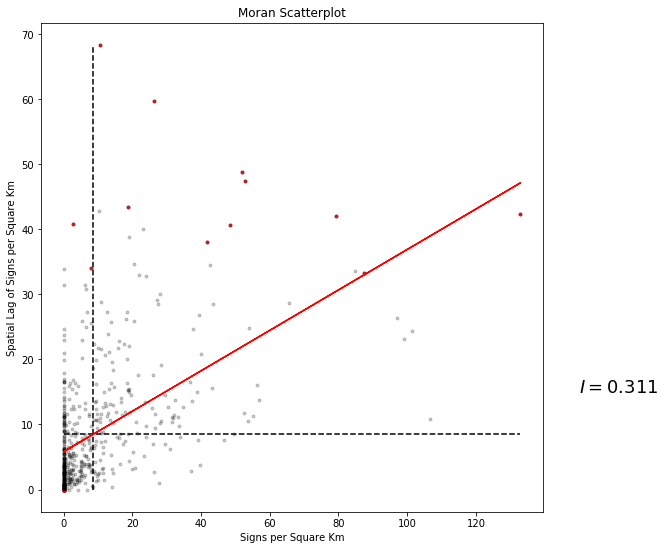

In [24]:
f, ax = plt.subplots(1, figsize=(9,9))

plt.plot(sigs, W_sigs, '.', color='firebrick')
plt.plot(insigs, W_insigs, '.k', alpha=.2)

# dashed vert at mean of the signs per square Km
plt.vlines(signs.mean(), Lag_signs.min(), Lag_signs.max(), linestyle='--')

# dashed horizontal at mean of lagged signs per square Km
plt.hlines(Lag_signs.mean(), signs.min(), signs.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(signs, a+b*signs, 'r')

plt.text(s='$I = %.3f$' % I_signs.I, x=150, y=15, fontsize=18)
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Signs per Square Km')
plt.xlabel('Signs per Square Km')

plt.show()

#### NOTE:
Map the LISA data:

In [25]:
sig = LMo_signs.p_sim < 0.05

In [26]:
sig.sum()

153

In [27]:
# Gather the tracts that would appear in the HH quadrant (Q1)
# representing above average observations
hotspots = LMo_signs.q==1 * sig

In [28]:
hotspots.sum()

40

In [29]:
# Gather the tracts that would appear in the LL quadrant (Q3)
# representing below average observations
coldspots = LMo_signs.q==3 * sig

In [30]:
coldspots.sum()

95

In [31]:
gdf_demproj['Signs_Per_Square_Km'][hotspots]

11      19.041610
12      27.410187
13      96.921064
14      23.184040
15      79.340934
16      10.171686
17      26.233511
18      84.831879
19      10.580492
20     132.896709
21      48.515933
22      52.026905
23      42.648091
24      28.124593
35      20.391673
36      12.919695
39      18.778917
40      24.092077
41      52.742080
42      87.534635
44       8.870618
46      22.035447
47      18.987825
49      18.373261
50      10.834034
67      15.705270
73      65.527835
74      20.505033
77      53.891852
78      41.630082
107     27.303472
118     98.978543
120     18.176600
122     13.831815
130     16.233272
131     39.402059
132     12.520032
133     43.483006
181     18.584524
183     37.514297
Name: Signs_Per_Square_Km, dtype: float64

In [32]:
gdf_demproj.loc[hotspots,['spatial_id', 'name', 'Signs_Per_Square_Km']].head(10)

spatial_id                    name  Signs_Per_Square_Km
11  5350010.01  CT0010.01, Toronto, ON            19.041610
12  5350010.02  CT0010.02, Toronto, ON            27.410187
13  5350011.00  CT0011.00, Toronto, ON            96.921064
14  5350012.01  CT0012.01, Toronto, ON            23.184040
15  5350012.03  CT0012.03, Toronto, ON            79.340934
16  5350012.04  CT0012.04, Toronto, ON            10.171686
17  5350013.01  CT0013.01, Toronto, ON            26.233511
18  5350013.02  CT0013.02, Toronto, ON            84.831879
19  5350014.00  CT0014.00, Toronto, ON            10.580492
20  5350015.00  CT0015.00, Toronto, ON           132.896709

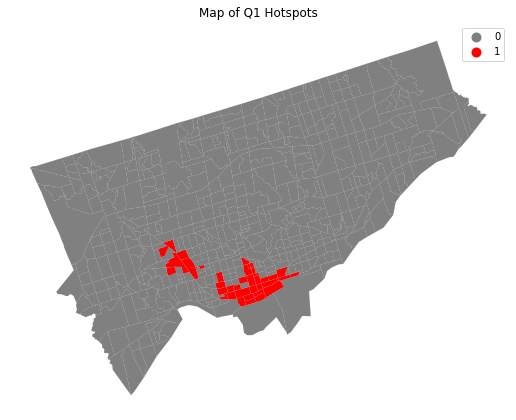

In [33]:
hmap = colors.ListedColormap(['grey', 'red'])

f, ax = plt.subplots(1, figsize=(9,9))
gdf_demproj.assign(cl=hotspots*1).plot(column='cl', categorical=True, \
                                      k=2, cmap=hmap, linewidth=0.1, ax=ax, \
                                      edgecolor='grey', legend=True)
ax.set_title('Map of Q1 Hotspots')
ax.set_axis_off()
plt.show()

In [34]:
gdf_demproj.loc[coldspots,['spatial_id', 'name', 'Signs_Per_Square_Km']].head(10)

spatial_id                    name  Signs_Per_Square_Km
5    5350006.00  CT0006.00, Toronto, ON             0.000000
124  5350102.02  CT0102.02, Toronto, ON             0.000000
144  5350119.00  CT0119.00, Toronto, ON             0.000000
146  5350121.00  CT0121.00, Toronto, ON             6.727229
169  5350139.02  CT0139.02, Toronto, ON             3.926011
226  5350194.02  CT0194.02, Toronto, ON             0.000000
255  5350218.00  CT0218.00, Toronto, ON             1.464426
261  5350222.02  CT0222.02, Toronto, ON             0.000000
262  5350223.01  CT0223.01, Toronto, ON             0.000000
264  5350224.00  CT0224.00, Toronto, ON             0.000000

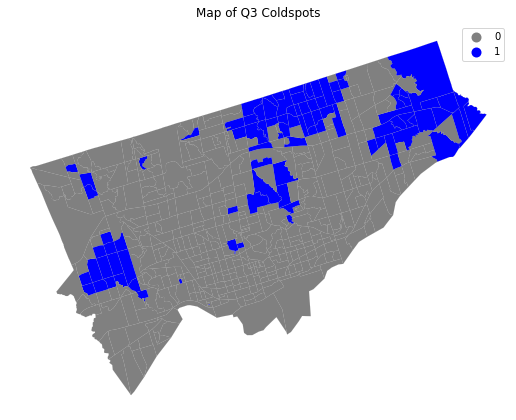

In [35]:
cmap = colors.ListedColormap(['grey', 'blue'])

f, ax = plt.subplots(1, figsize=(9,9))
gdf_demproj.assign(cl=coldspots*1).plot(column='cl', categorical=True, \
                                      k=2, cmap=cmap, linewidth=0.1, ax=ax, \
                                      edgecolor='grey', legend=True)
ax.set_title('Map of Q3 Coldspots')
ax.set_axis_off()
plt.show()

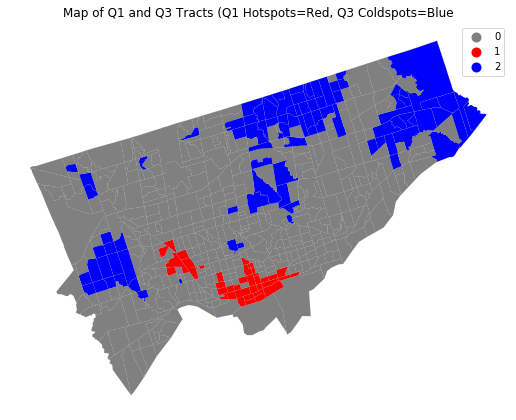

In [36]:
hcmap = colors.ListedColormap(['grey', 'red', 'blue'])
hotcold = hotspots*1 + coldspots*2
f, ax = plt.subplots(1, figsize=(9,9))
gdf_demproj.assign(cl=hotcold).plot(column='cl', categorical=True, \
                                      k=2, cmap=hcmap, linewidth=0.1, ax=ax, \
                                      edgecolor='grey', legend=True)
ax.set_title('Map of Q1 and Q3 Tracts (Q1 Hotspots=Red, Q3 Coldspots=Blue')
ax.set_axis_off()
plt.show()

#### NOTE:
The above illustrates the cluster of tracts with significantly higher number of signs per square kilometer in red, and significantly lower number of signs per square kilometer in blue.  Higher numbers tend to be clustered in the heart of the city while lower values tend to be found towards the outer edges.

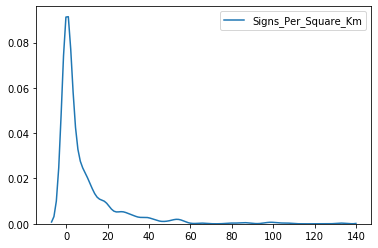

In [37]:
sns.kdeplot(gdf_demproj['Signs_Per_Square_Km'])

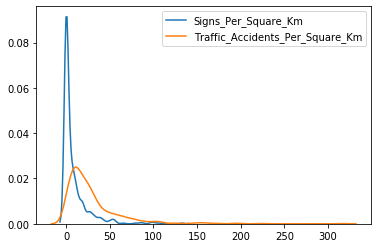

In [38]:
sns.kdeplot(gdf_demproj['Signs_Per_Square_Km'])
sns.kdeplot(gdf_demproj['Traffic_Accidents_Per_Square_Km'])

In [39]:
gdf_demproj['Signs_Per_Square_Km'].mean()

8.646983952428505

In [40]:
gdf_demproj['Signs_Per_Square_Km'].median()

1.957350295442704

## II.  Spatial Autocorrelation - Traffic Accidents per Signs per Square Km
While the above was effective in illustrating how the signs are clustered in the city, it still requires a way of linking this information to the nearby traffic accidents.  In order to accomplish this requirement, the following will look at the traffic accidents per sign per square kilometer.

### Spatial Similarity
Determine how geographically similar a region is with another.

In [41]:
# Determine the number of traffic accidents per sign per square km
# If there are no signs, use zero
gdf_demproj['Acc_Per_Sign_Per_Km'] = 0
gdf_demproj.loc[gdf_demproj['Signs_Per_Square_Km'] > 0, 'Acc_Per_Sign_Per_Km'] = \
                gdf_demproj['Traffic_Accidents_Per_Square_Km'] / gdf_demproj['Signs_Per_Square_Km']
gdf_demproj.head()

spatial_id                    name  Total_Household_Count  \
0  5350001.00  CT0001.00, Toronto, ON                  249.0   
1  5350002.00  CT0002.00, Toronto, ON                  267.0   
2  5350003.00  CT0003.00, Toronto, ON                  537.0   
3  5350004.00  CT0004.00, Toronto, ON                 3712.0   
4  5350005.00  CT0005.00, Toronto, ON                 3722.0   

   Total_Population_Count  Total_Income_Over_100K_Count  \
0                   600.0                          88.0   
1                   613.0                          74.0   
2                  1557.0                         219.0   
3                  7177.0                         342.0   
4                  6969.0                         445.0   

   Total_Income_Over_250K_Count  Avg_Household_Income_Dollars  \
0                          15.0                     120561.50   
1                           7.0                      75392.63   
2                          28.0                     120833.84   
3                         121.0                      54432.35   
4                         127.0                      65003.69   

   Median_Household_Income_Dollars  \
0                         79727.91   
1                         74505.79   
2                         88073.28   
3                         27670.45   
4                         33807.26   

   Total_Population_Languages_No_Eng_French_Count  \
0                                            22.0   
1                                             0.0   
2                                            17.0   
3                                           392.0   
4                                           301.0   

   Total_Houshold_Mother_Tongue_Eng_Pct  ...  Above_Avg_Over_100K_Count  \
0                               72.5000  ...                          0   
1                               89.1566  ...                          0   
2                               53.8462  ...                          0   
3                               50.0513  ...                          0   
4                               55.8916  ...                          0   

   Above_Avg_Over_250K_Count  Above_Avg_Pop_No_Eng_Fr_Count  \
0                          0                              0   
1                          0                              0   
2                          0                              0   
3                          0                              1   
4                          0                              1   

   Above_Avg_Pop_Eng_First_Count  Above_Avg_Consumption_Dollars  \
0                              1                              0   
1                              1                              0   
2                              1                              0   
3                              0                              0   
4                              1                              1   

   Above_Avg_Expenditure_Dollars  Above_Med_AvgHousehold_Income_Dollars  \
0                              0                                      1   
1                              0                                      0   
2                              0                                      1   
3                              0                                      0   
4                              0                                      0   

   Above_Med_MedHousehold_Income_Dollars  \
0                                      1   
1                                      1   
2                                      1   
3                                      0   
4                                      0   

                                            geometry  Acc_Per_Sign_Per_Km  
0  POLYGON ((320680.3743114723 4835111.663189559,...             0.755556  
1  POLYGON ((317005.3262185335 4832246.620448819,...             0.000000  
2  POLYGON ((310090.9919327127 4832634.009787658,...            19.285714  
3  POLYGON ((309961.8252407954 4833027.383222284,...             2.7500

C:\Users\Mills\Anaconda3\lib\site-packages\pysal\viz\mapclassify\classifiers.py:95: UserWarning: Warning: Not enough unique values in array to form k classes
  UserWarning)
C:\Users\Mills\Anaconda3\lib\site-packages\pysal\viz\mapclassify\classifiers.py:96: UserWarning: Warning: setting k to 7
  Warn('Warning: setting k to %d' % k_q, UserWarning)


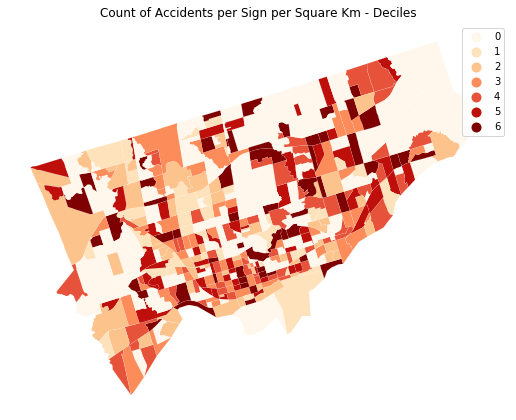

In [42]:
# Visualize the Deciles of sign locations
acc_signs10 = mc.Quantiles(gdf_demproj['Acc_Per_Sign_Per_Km'], k=10)

f, ax = plt.subplots(1, figsize=(9,9))
gdf_demproj.assign(cl=acc_signs10.yb).plot(column='cl', categorical=True, \
                                      k=10, cmap='OrRd', linewidth=0.1, ax=ax, \
                                      edgecolor='white', legend=True)
ax.set_axis_off()
plt.title('Count of Accidents per Sign per Square Km - Deciles')
plt.show()

#### NOTE:
Initially, similar regions appear to be more randomly scattered when compared to the similar map produced by using only the signs per square kilometer data.

In [43]:
# Use queen contiguity to apply weights
W = ps.lib.weights.Queen.from_dataframe(gdf_demproj)

# Standardize the rows so all values range from 0 to 1, and the row sum is 1
W.transform = 'r'


### Attribute Similarity
Spatial lag is used to measure how similar the attributes are between regions.

In [44]:
acc_signs10Lag = ps.lib.weights.lag_spatial(W, gdf_demproj['Acc_Per_Sign_Per_Km'])

In [45]:
acc_signs10LagQ10 = mc.Quantiles(acc_signs10Lag, k=10)

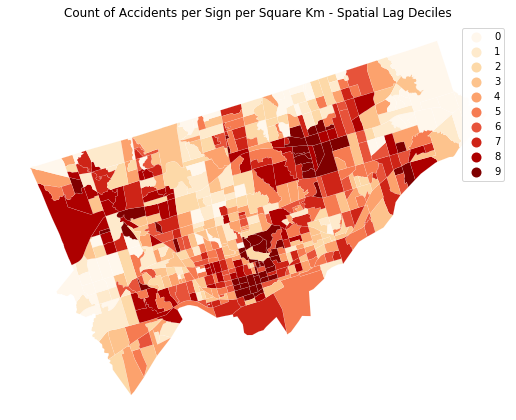

In [46]:
f, ax = plt.subplots(1, figsize=(9,9))

gdf_demproj.assign(cl=acc_signs10LagQ10.yb).plot(column='cl', categorical=True, \
                                      k=10, cmap='OrRd', linewidth=0.1, ax=ax, \
                                      edgecolor='white', legend=True)
ax.set_axis_off()
plt.title('Count of Accidents per Sign per Square Km - Spatial Lag Deciles')
plt.show()

#### NOTE:
While mapping the spatial lag does appear to visually enhance some clusters, it does again appear to be more randomized compared to the signs per square kilometer map.

How does the above visualization translate in statistical measures?

In [47]:
acc_signs = gdf_demproj['Acc_Per_Sign_Per_Km']
b, a = np.polyfit(acc_signs, acc_signs10Lag, 1)

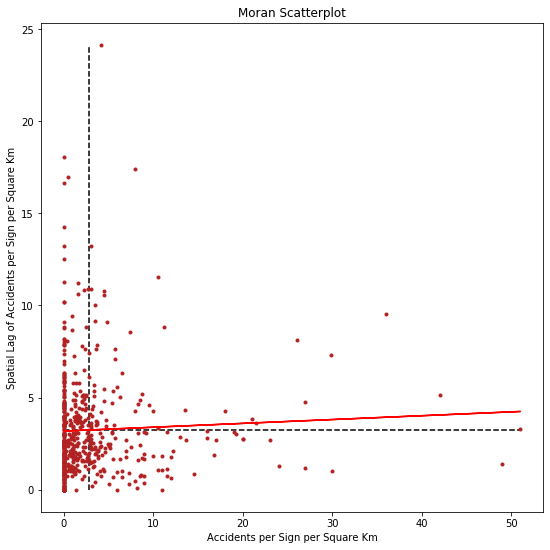

In [48]:
f, ax = plt.subplots(1, figsize=(9,9))

plt.plot(acc_signs, acc_signs10Lag, '.', color='firebrick')

# dashed vert at mean of the accidents per sign per square Km
plt.vlines(acc_signs.mean(), acc_signs10Lag.min(), acc_signs10Lag.max(), linestyle='--')

# dashed horizontal at mean of lagged accidents per sign per square Km
plt.hlines(acc_signs10Lag.mean(), acc_signs.min(), acc_signs.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(acc_signs, a+b*acc_signs, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Accidents per Sign per Square Km')
plt.xlabel('Accidents per Sign per Square Km')
plt.show()

### Global Spatial Autocorrelation
Compute Moran's $I$ statistic to examine the spatial dependence in the Accidents per Sign per Square Km:

In [49]:
I_acc_signs = ps.explore.esda.Moran(gdf_demproj['Acc_Per_Sign_Per_Km'].values, W)

In [50]:
print('The I statistic is ', I_acc_signs.I)
print('The slope of the line is ', b)
print('The p value is ', I_acc_signs.p_sim)

The I statistic is  0.020861565833143532
The slope of the line is  0.020861565833143598
The p value is  0.174


Using the stored collection of simulated $I$ statistics, visualize the results:

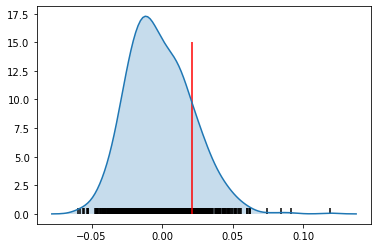

In [51]:
sns.kdeplot(I_acc_signs.sim, shade=True)
plt.vlines(I_acc_signs.sim, 0, 0.5)
plt.vlines(I_acc_signs.I, 0, 15, 'r')

What if the $I$ statistic were close to the expected value of $I$?

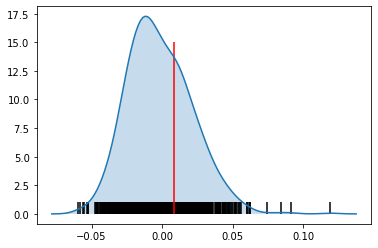

In [52]:
sns.kdeplot(I_acc_signs.sim, shade=True)
plt.vlines(I_acc_signs.sim, 0, 1)
plt.vlines(I_acc_signs.EI+0.01, 0, 15, 'r')


#### NOTE:
Based on a Moran's $I$ value of 0.02, we can conclude that there is no autocorrelation, indicating close to perfect randomness (ie. $I$ is almost a zero value).  The $p$-value of 0.181 indicates that this $I$ value could have been generated by chance.  We cannot reject the null hypothesis here.

Interpretation of $I$ was found on this site:  https://www.statisticshowto.datasciencecentral.com/morans-i/

### Local Autocorrelation Statistics

In [53]:
LMo_acc_signs = ps.explore.esda.Moran_Local(gdf_demproj['Acc_Per_Sign_Per_Km'].values, W)

In [54]:
# Check the array of I statistics and p-values
LMo_acc_signs.Is[0:10], LMo_acc_signs.p_sim[0:10]

(array([ 0.008546  , -0.07552645,  0.07358024, -0.00222352,  0.04388362,
         0.24996317, -0.14640229, -0.01729986,  0.0164991 , -0.05404939]),
 array([0.413, 0.241, 0.373, 0.28 , 0.335, 0.001, 0.197, 0.203, 0.402,
        0.209]))

Adjust the number of permutations to derive every pseudo-$p$ value:

In [55]:
LMo_acc_signs = ps.explore.esda.Moran_Local(gdf_demproj['Acc_Per_Sign_Per_Km'].values, W, permutations=9999)

#### NOTE:
Visualize the Local indicators of spatial association (LISA) statistics.  Highlight the statistically significant LISAs.

In [56]:
# Construct the spatial lag of the covariate
Lag_acc_signs = ps.lib.weights.lag_spatial(W, gdf_demproj['Acc_Per_Sign_Per_Km'].values)
acc_signs = gdf_demproj['Acc_Per_Sign_Per_Km'].values

In [57]:
# Find the significant and insignificant values
acc_sigs = acc_signs[LMo_acc_signs.p_sim <= 0.001]
acc_W_sigs = Lag_acc_signs[LMo_acc_signs.p_sim <= 0.001]
acc_insigs = acc_signs[LMo_acc_signs.p_sim > 0.001]
acc_W_insigs = Lag_acc_signs[LMo_acc_signs.p_sim > 0.001]

In [58]:
b, a = np.polyfit(acc_signs, Lag_acc_signs, 1)

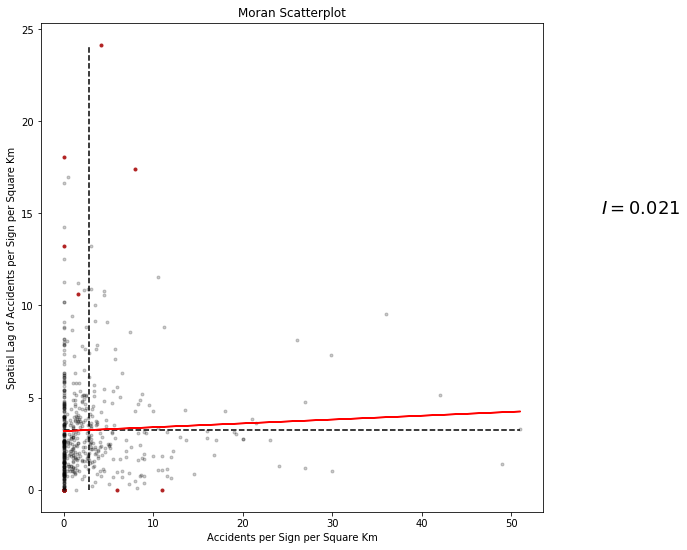

In [59]:
f, ax = plt.subplots(1, figsize=(9,9))

plt.plot(acc_sigs, acc_W_sigs, '.', color='firebrick')
plt.plot(acc_insigs, acc_W_insigs, '.k', alpha=.2)

# dashed vert at mean of the last year's PCI
plt.vlines(acc_signs.mean(), Lag_acc_signs.min(), Lag_acc_signs.max(), linestyle='--')

# dashed horizontal at mean of lagged PCI
plt.hlines(Lag_acc_signs.mean(), acc_signs.min(), acc_signs.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(acc_signs, a+b*acc_signs, 'r')

plt.text(s='$I = %.3f$' % I_acc_signs.I, x=60, y=15, fontsize=18)
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Accidents per Sign per Square Km')
plt.xlabel('Accidents per Sign per Square Km')

plt.show()

#### NOTE:
Map the LISA data:

In [60]:
acc_sig = LMo_acc_signs.p_sim < 0.05

In [61]:
acc_sig.sum()

79

In [62]:
acc_hotspots = LMo_acc_signs.q==1 * acc_sig

In [63]:
acc_hotspots.sum()

16

In [64]:
acc_coldspots = LMo_acc_signs.q==3 * acc_sig

In [65]:
acc_coldspots.sum()

30

In [66]:
gdf_demproj['Acc_Per_Sign_Per_Km'][acc_hotspots]

17      5.666667
38     10.500000
40      3.000000
41      3.714286
43     36.000000
44     11.250000
45      7.428571
46      4.857143
76      4.500000
79      8.000000
329     3.500000
331     4.500000
334     3.000000
379     3.444444
518     4.142857
520    26.000000
Name: Acc_Per_Sign_Per_Km, dtype: float64

In [67]:
gdf_demproj.loc[acc_hotspots,['spatial_id', 'name', 'Acc_Per_Sign_Per_Km']].head(10)

spatial_id                    name  Acc_Per_Sign_Per_Km
17  5350013.01  CT0013.01, Toronto, ON             5.666667
38  5350032.00  CT0032.00, Toronto, ON            10.500000
40  5350034.01  CT0034.01, Toronto, ON             3.000000
41  5350034.02  CT0034.02, Toronto, ON             3.714286
43  5350036.00  CT0036.00, Toronto, ON            36.000000
44  5350037.00  CT0037.00, Toronto, ON            11.250000
45  5350038.00  CT0038.00, Toronto, ON             7.428571
46  5350039.00  CT0039.00, Toronto, ON             4.857143
76  5350063.04  CT0063.04, Toronto, ON             4.500000
79  5350064.00  CT0064.00, Toronto, ON             8.000000

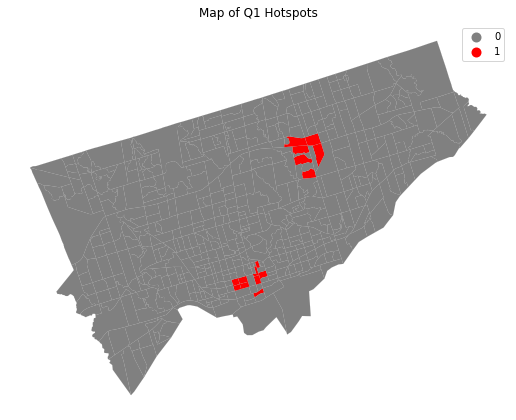

In [68]:
hmap = colors.ListedColormap(['grey', 'red'])

f, ax = plt.subplots(1, figsize=(9,9))
gdf_demproj.assign(cl=acc_hotspots*1).plot(column='cl', categorical=True, \
                                      k=2, cmap=hmap, linewidth=0.1, ax=ax, \
                                      edgecolor='grey', legend=True)
ax.set_title('Map of Q1 Hotspots')
ax.set_axis_off()
plt.show()

In [69]:
gdf_demproj.loc[acc_coldspots,['spatial_id', 'name', 'Acc_Per_Sign_Per_Km']].head(10)

spatial_id                    name  Acc_Per_Sign_Per_Km
5    5350006.00  CT0006.00, Toronto, ON             0.000000
173  5350142.00  CT0142.00, Toronto, ON             0.000000
261  5350222.02  CT0222.02, Toronto, ON             0.000000
262  5350223.01  CT0223.01, Toronto, ON             0.000000
272  5350230.02  CT0230.02, Toronto, ON             0.000000
274  5350232.00  CT0232.00, Toronto, ON             1.333333
275  5350233.00  CT0233.00, Toronto, ON             0.000000
276  5350234.00  CT0234.00, Toronto, ON             0.000000
288  5350240.02  CT0240.02, Toronto, ON             0.000000
342  5350277.00  CT0277.00, Toronto, ON             2.076923

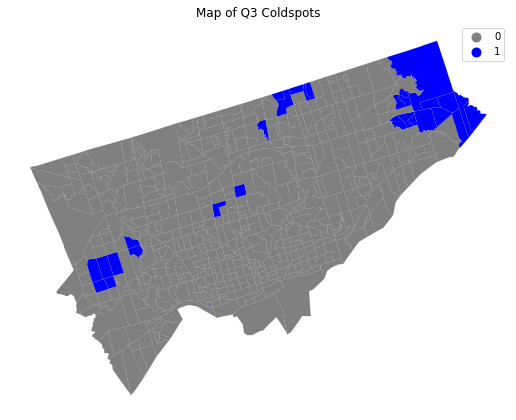

In [70]:
cmap = colors.ListedColormap(['grey', 'blue'])

f, ax = plt.subplots(1, figsize=(9,9))
gdf_demproj.assign(cl=acc_coldspots*1).plot(column='cl', categorical=True, \
                                      k=2, cmap=cmap, linewidth=0.1, ax=ax, \
                                      edgecolor='grey', legend=True)
ax.set_title('Map of Q3 Coldspots')
ax.set_axis_off()
plt.show()

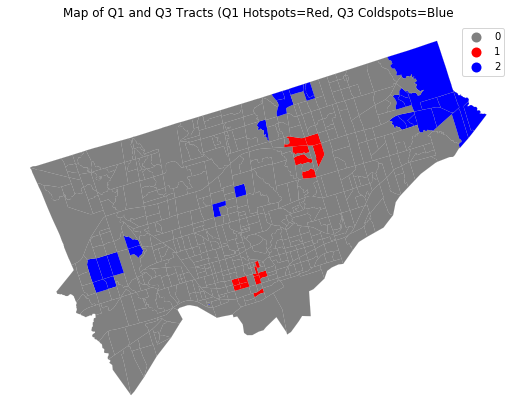

In [71]:
hcmap = colors.ListedColormap(['grey', 'red', 'blue'])
acc_hotcold = acc_hotspots*1 + acc_coldspots*2
f, ax = plt.subplots(1, figsize=(9,9))
gdf_demproj.assign(cl=acc_hotcold).plot(column='cl', categorical=True, \
                                      k=2, cmap=hcmap, linewidth=0.1, ax=ax, \
                                      edgecolor='grey', legend=True)
ax.set_title('Map of Q1 and Q3 Tracts (Q1 Hotspots=Red, Q3 Coldspots=Blue')
ax.set_axis_off()
plt.show()

#### NOTE:
Two hotspots relating to the number of accidents per sign per square kilometer are visible in the above, while the coldspots are pushed again to the outer edges of the city.  The exception to this includes a couple of coldspots in the center.

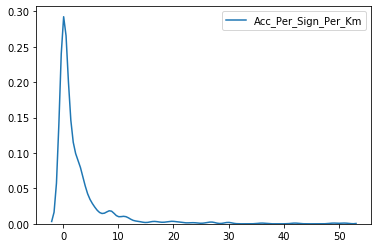

In [72]:
sns.kdeplot(gdf_demproj['Acc_Per_Sign_Per_Km'])

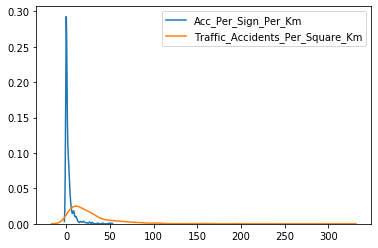

In [73]:
sns.kdeplot(gdf_demproj['Acc_Per_Sign_Per_Km'])
sns.kdeplot(gdf_demproj['Traffic_Accidents_Per_Square_Km'])

In [74]:
gdf_demproj['Acc_Per_Sign_Per_Km'].mean()

2.8699004396706

In [75]:
gdf_demproj['Acc_Per_Sign_Per_Km'].median()

0.9372549019607843

## III.  Spatial Autocorrelation
## Traffic Accidents per Signs per Square Km - Limited to Above Average Population Count Tracts
What happens if the dataset is restricted to a subset of records known to have a high number of signs?  For the following, a dataset is created consisting only of the records where the tracts consist of population numbers above the average per tract.  During the data discovery phase, these tracts were found to have over 60% of the signs.

### Spatial Similarity
Determine how geographically similar a region is with another.

In [76]:
# Filter the dataset to only tracts with above average population counts
gdf_pop = gdf_demproj[gdf_demproj['Above_Avg_Population_Count']==1]
gdf_pop.head()

spatial_id                    name  Total_Household_Count  \
3   5350004.00  CT0004.00, Toronto, ON                 3712.0   
4   5350005.00  CT0005.00, Toronto, ON                 3722.0   
8   5350008.01  CT0008.01, Toronto, ON                 5434.0   
9   5350008.02  CT0008.02, Toronto, ON                 6680.0   
11  5350010.01  CT0010.01, Toronto, ON                 3438.0   

    Total_Population_Count  Total_Income_Over_100K_Count  \
3                   7177.0                         342.0   
4                   6969.0                         445.0   
8                   8228.0                        2294.0   
9                  10952.0                        1906.0   
11                  5927.0                        1521.0   

    Total_Income_Over_250K_Count  Avg_Household_Income_Dollars  \
3                          121.0                      54432.35   
4                          127.0                      65003.69   
8                          325.0                     138811.86   
9                          350.0                     110150.38   
11                         232.0                     140155.00   

    Median_Household_Income_Dollars  \
3                          27670.45   
4                          33807.26   
8                          90550.60   
9                          77824.29   
11                         91780.07   

    Total_Population_Languages_No_Eng_French_Count  \
3                                            392.0   
4                                            301.0   
8                                             34.0   
9                                            156.0   
11                                           119.0   

    Total_Houshold_Mother_Tongue_Eng_Pct  ...  Above_Avg_Over_100K_Count  \
3                                50.0513  ...                          0   
4                                55.8916  ...                          0   
8                                74.5017  ...                          1   
9                                64.7502  ...                          1   
11                               71.2897  ...                          1   

    Above_Avg_Over_250K_Count  Above_Avg_Pop_No_Eng_Fr_Count  \
3                           0                              1   
4                           0                              1   
8                           1                              0   
9                           1                              0   
11                          1                              0   

    Above_Avg_Pop_Eng_First_Count  Above_Avg_Consumption_Dollars  \
3                               0                              0   
4                               1                              1   
8                               1                              1   
9                               1                              1   
11                              1                              1   

    Above_Avg_Expenditure_Dollars  Above_Med_AvgHousehold_Income_Dollars  \
3                               0                                      0   
4                               0                                      0   
8                               1                                      1   
9                               1                                      1   
11                              1                                      1   

    Above_Med_MedHousehold_Income_Dollars  \
3                                       0   
4                                       0   
8                                       1   
9                                       1   
11                                      1   

                                             geometry  Acc_Per_Sign_Per_Km  
3   POLYGON ((309961.8252407954 4833027.383222284,...             2.750000  
4   POLYGON ((310885.1759646178 4833459.156552648,...             1.600000  
8   POLYGON ((311994.0111354634 4833258.618734809,...             0.000000  
9   POLY

In [77]:
gdf_pop.shape

(271, 29)

C:\Users\Mills\Anaconda3\lib\site-packages\pysal\viz\mapclassify\classifiers.py:95: UserWarning: Warning: Not enough unique values in array to form k classes
  UserWarning)
C:\Users\Mills\Anaconda3\lib\site-packages\pysal\viz\mapclassify\classifiers.py:96: UserWarning: Warning: setting k to 8
  Warn('Warning: setting k to %d' % k_q, UserWarning)


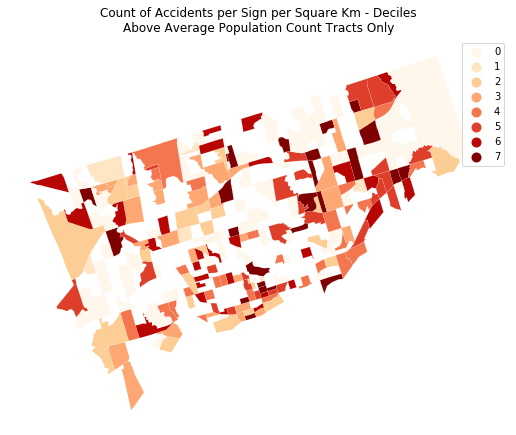

In [78]:
# Visualize the Deciles of sign locations
pop_acc_signs10 = mc.Quantiles(gdf_pop['Acc_Per_Sign_Per_Km'], k=10)

f, ax = plt.subplots(1, figsize=(9,9))
gdf_pop.assign(cl=pop_acc_signs10.yb).plot(column='cl', categorical=True, \
                                      k=10, cmap='OrRd', linewidth=0.1, ax=ax, \
                                      edgecolor='white', legend=True)
ax.set_axis_off()
plt.title('Count of Accidents per Sign per Square Km - Deciles\nAbove Average Population Count Tracts Only')
plt.show()

#### NOTE:
The whitespace represents areas excluded from the dataset for containing the tracts with below average population counts.  As with the previous analysis, the colouring appears to be spread at random throughout the city.

In [79]:
# Use queen contiguity to apply weights
W = ps.lib.weights.Queen.from_dataframe(gdf_pop)

# Standardize the rows so all values range from 0 to 1, and the row sum is 1
W.transform = 'r'


C:\Users\Mills\Anaconda3\lib\site-packages\pysal\lib\weights\weights.py:168: UserWarning: There are 3 disconnected observations 
  Island ids: 16, 82, 270
  " Island ids: %s" % ', '.join(str(island) for island in self.islands))


('WARNING: ', 16, ' is an island (no neighbors)')
('WARNING: ', 82, ' is an island (no neighbors)')
('WARNING: ', 270, ' is an island (no neighbors)')


### Attribute Similarity
Spatial lag is used to measure how similar the attributes are between regions.

In [80]:
pop_acc_signs10Lag = ps.lib.weights.lag_spatial(W, gdf_pop['Acc_Per_Sign_Per_Km'])

In [81]:
pop_acc_signs10LagQ10 = mc.Quantiles(pop_acc_signs10Lag, k=10)

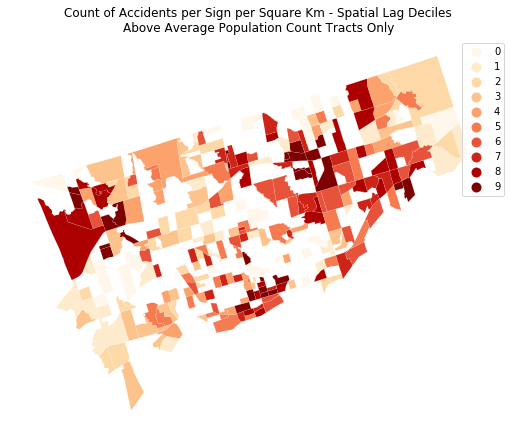

In [82]:
f, ax = plt.subplots(1, figsize=(9,9))

gdf_pop.assign(cl=pop_acc_signs10LagQ10.yb).plot(column='cl', categorical=True, \
                                      k=10, cmap='OrRd', linewidth=0.1, ax=ax, \
                                      edgecolor='white', legend=True)
ax.set_axis_off()
plt.title('Count of Accidents per Sign per Square Km - Spatial Lag Deciles\nAbove Average Population Count Tracts Only')
plt.show()

#### NOTE:
Some clustering of tracts begins to emerge in the spatial lag data, but not to the extent that was observed in the signs per square kilometer analysis.

How does the above visualization translate in statistical measures?

In [83]:
pop_acc_signs = gdf_pop['Acc_Per_Sign_Per_Km']
b, a = np.polyfit(pop_acc_signs, pop_acc_signs10Lag, 1)

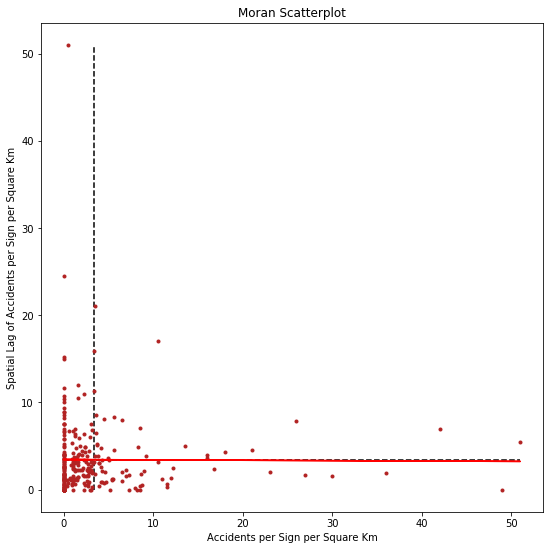

In [84]:
f, ax = plt.subplots(1, figsize=(9,9))

plt.plot(pop_acc_signs, pop_acc_signs10Lag, '.', color='firebrick')

# dashed vert at mean of the accidents per sign per square Km (above average population tracts only)
plt.vlines(pop_acc_signs.mean(), pop_acc_signs10Lag.min(), pop_acc_signs10Lag.max(), linestyle='--')

# dashed horizontal at mean of lagged accidents per sign per square Km (above average population tracts only)
plt.hlines(pop_acc_signs10Lag.mean(), pop_acc_signs.min(), pop_acc_signs.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(pop_acc_signs, a+b*pop_acc_signs, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Accidents per Sign per Square Km')
plt.xlabel('Accidents per Sign per Square Km')
plt.show()

### Global Spatial Autocorrelation
Compute Moran's $I$ statistic to examine the spatial dependence in the Accidents per Sign per Square Km:

In [85]:
I_pop_acc_signs = ps.explore.esda.Moran(gdf_pop['Acc_Per_Sign_Per_Km'].values, W)

In [86]:
print('The I statistic is ', I_pop_acc_signs.I)
print('The slope of the line is ', b)
print('The p value is ', I_pop_acc_signs.p_sim)

The I statistic is  -0.004876498833389906
The slope of the line is  -0.0042813258949303224
The p value is  0.443


Using the stored collection of simulated $I$ statistics, visualize the results:

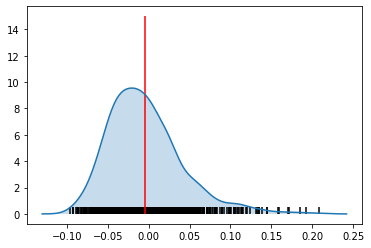

In [87]:
sns.kdeplot(I_pop_acc_signs.sim, shade=True)
plt.vlines(I_pop_acc_signs.sim, 0, 0.5)
plt.vlines(I_pop_acc_signs.I, 0, 15, 'r')

What if the $I$ statistic were close to the expected value of $I$?

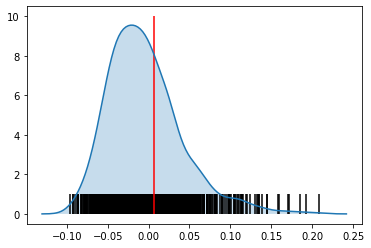

In [88]:
sns.kdeplot(I_pop_acc_signs.sim, shade=True)
plt.vlines(I_pop_acc_signs.sim, 0, 1)
plt.vlines(I_pop_acc_signs.EI+0.01, 0, 10, 'r')


Based on a Moran's $I$ value of -0.004, we can conclude that there is no autocorrelation, indicating close to perfect randomness (ie. $I$ is almost a zero value).  The $p$-value of 0.443 indicates that this $I$ value very likely could have been generated by chance.  We cannot reject the null hypothesis here.

Interpretation of $I$ was found on this site:  https://www.statisticshowto.datasciencecentral.com/morans-i/

### Local Autocorrelation Statistics

In [89]:
LMo_pop_acc_signs = ps.explore.esda.Moran_Local(gdf_pop['Acc_Per_Sign_Per_Km'].values, W)

C:\Users\Mills\Anaconda3\lib\site-packages\pysal\explore\esda\moran.py:895: RuntimeWarning: invalid value encountered in true_divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
C:\Users\Mills\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Mills\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Mills\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0


In [90]:
# Check the array of I statistics and p-values
LMo_pop_acc_signs.Is[0:10], LMo_pop_acc_signs.p_sim[0:10]

(array([ 0.02367509,  0.02033511,  0.04684762,  0.04664496, -0.03473128,
        -0.00567305, -0.27090085, -0.05998591, -0.10451467, -0.30107948]),
 array([0.421, 0.418, 0.436, 0.462, 0.436, 0.346, 0.058, 0.193, 0.176,
        0.491]))

Adjust the number of permutations to derive every pseudo-$p$ value:

In [91]:
LMo_pop_acc_signs = ps.explore.esda.Moran_Local(gdf_pop['Acc_Per_Sign_Per_Km'].values, W, permutations=9999)

#### NOTE:
Visualize the Local indicators of spatial association (LISA) statistics.  Highlight the statistically significant LISAs.

In [92]:
# Construct the spatial lag of the covariate
Lag_pop_acc_signs = ps.lib.weights.lag_spatial(W, gdf_pop['Acc_Per_Sign_Per_Km'].values)
pop_acc_signs = gdf_pop['Acc_Per_Sign_Per_Km'].values

In [93]:
# Find the significant and insignificant values
pop_acc_sigs = pop_acc_signs[LMo_pop_acc_signs.p_sim <= 0.001]
pop_acc_W_sigs = Lag_pop_acc_signs[LMo_pop_acc_signs.p_sim <= 0.001]
pop_acc_insigs = pop_acc_signs[LMo_pop_acc_signs.p_sim > 0.001]
pop_acc_W_insigs = Lag_pop_acc_signs[LMo_pop_acc_signs.p_sim > 0.001]

In [94]:
b, a = np.polyfit(pop_acc_signs, Lag_pop_acc_signs, 1)

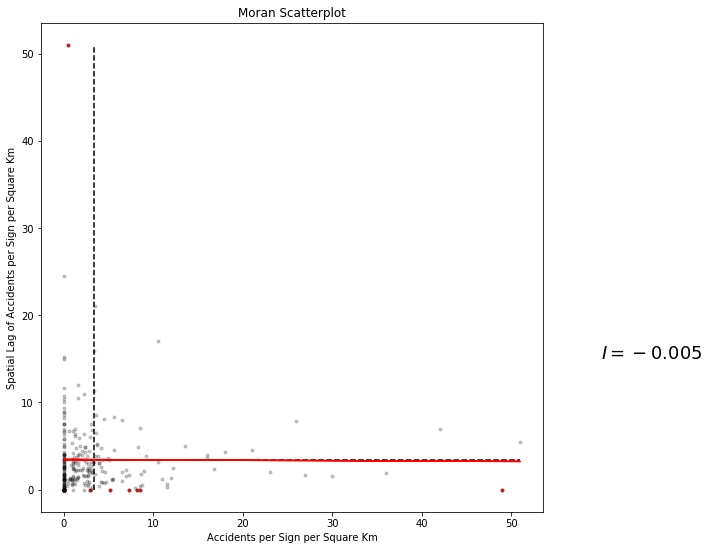

In [95]:
f, ax = plt.subplots(1, figsize=(9,9))

plt.plot(pop_acc_sigs, pop_acc_W_sigs, '.', color='firebrick')
plt.plot(pop_acc_insigs, pop_acc_W_insigs, '.k', alpha=.2)

# dashed vert at mean of the last accidents per sign per square Km (above average population tracts only)
plt.vlines(pop_acc_signs.mean(), Lag_pop_acc_signs.min(), Lag_pop_acc_signs.max(), linestyle='--')

# dashed horizontal at mean of lagged accidents per sign per square Km (above average population tracts only)
plt.hlines(Lag_pop_acc_signs.mean(), pop_acc_signs.min(), pop_acc_signs.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(pop_acc_signs, a+b*pop_acc_signs, 'r')

plt.text(s='$I = %.3f$' % I_pop_acc_signs.I, x=60, y=15, fontsize=18)
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Accidents per Sign per Square Km')
plt.xlabel('Accidents per Sign per Square Km')

plt.show()

#### NOTE:
Map the LISA data:

In [96]:
pop_acc_sig = LMo_pop_acc_signs.p_sim < 0.05

In [97]:
pop_acc_sig.sum()

32

In [98]:
pop_acc_hotspots = LMo_pop_acc_signs.q==1 * pop_acc_sig

In [99]:
pop_acc_hotspots.sum()

4

In [100]:
pop_acc_coldspots = LMo_pop_acc_signs.q==3 * pop_acc_sig

In [101]:
pop_acc_coldspots.sum()

14

In [102]:
gdf_pop['Acc_Per_Sign_Per_Km'][pop_acc_hotspots]

38     10.500000
204     3.428571
329     3.500000
379     3.444444
Name: Acc_Per_Sign_Per_Km, dtype: float64

In [103]:
gdf_pop.loc[pop_acc_hotspots,['spatial_id', 'name', 'Acc_Per_Sign_Per_Km']].head(10)

spatial_id                    name  Acc_Per_Sign_Per_Km
38   5350032.00  CT0032.00, Toronto, ON            10.500000
204  5350175.02  CT0175.02, Toronto, ON             3.428571
329  5350270.01  CT0270.01, Toronto, ON             3.500000
379  5350301.04  CT0301.04, Toronto, ON             3.444444

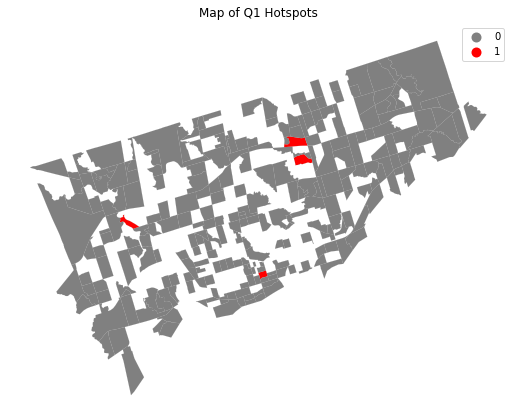

In [104]:
hmap = colors.ListedColormap(['grey', 'red'])

f, ax = plt.subplots(1, figsize=(9,9))
gdf_pop.assign(cl=pop_acc_hotspots*1).plot(column='cl', categorical=True, \
                                      k=2, cmap=hmap, linewidth=0.1, ax=ax, \
                                      edgecolor='grey', legend=True)
ax.set_title('Map of Q1 Hotspots')
ax.set_axis_off()
plt.show()

In [105]:
gdf_pop.loc[pop_acc_coldspots,['spatial_id', 'name', 'Acc_Per_Sign_Per_Km']].head(10)

spatial_id                    name  Acc_Per_Sign_Per_Km
31   5350026.00  CT0026.00, Toronto, ON             2.900000
250  5350213.02  CT0213.02, Toronto, ON             0.941176
260  5350222.01  CT0222.01, Toronto, ON             0.000000
261  5350222.02  CT0222.02, Toronto, ON             0.000000
280  5350236.02  CT0236.02, Toronto, ON             3.125000
495  5350361.02  CT0361.02, Toronto, ON             0.000000
496  5350362.01  CT0362.01, Toronto, ON             0.000000
497  5350362.02  CT0362.02, Toronto, ON             0.000000
498  5350362.03  CT0362.03, Toronto, ON             0.000000
499  5350362.04  CT0362.04, Toronto, ON             0.000000

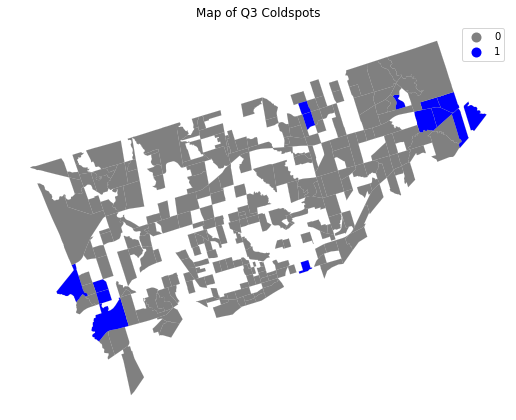

In [106]:
cmap = colors.ListedColormap(['grey', 'blue'])

f, ax = plt.subplots(1, figsize=(9,9))
gdf_pop.assign(cl=pop_acc_coldspots*1).plot(column='cl', categorical=True, \
                                      k=2, cmap=cmap, linewidth=0.1, ax=ax, \
                                      edgecolor='grey', legend=True)
ax.set_title('Map of Q3 Coldspots')
ax.set_axis_off()
plt.show()

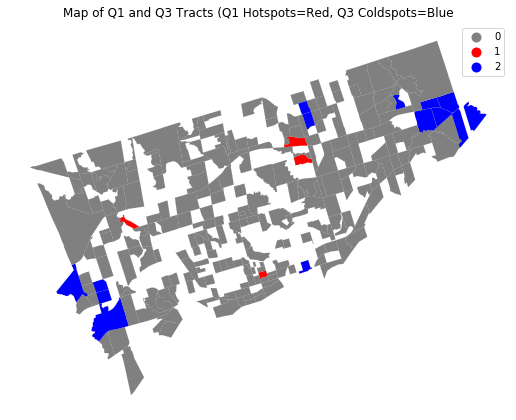

In [107]:
hcmap = colors.ListedColormap(['grey', 'red', 'blue'])
pop_acc_hotcold = pop_acc_hotspots*1 + pop_acc_coldspots*2
f, ax = plt.subplots(1, figsize=(9,9))
gdf_pop.assign(cl=pop_acc_hotcold).plot(column='cl', categorical=True, \
                                      k=2, cmap=hcmap, linewidth=0.1, ax=ax, \
                                      edgecolor='grey', legend=True)
ax.set_title('Map of Q1 and Q3 Tracts (Q1 Hotspots=Red, Q3 Coldspots=Blue')
ax.set_axis_off()
plt.show()

#### NOTE:
As with the previous analysis, the coldspots are found mainly along the outer edges of the city.  The hotspots are not limited to the south-central region as noted in the earlier analysis.

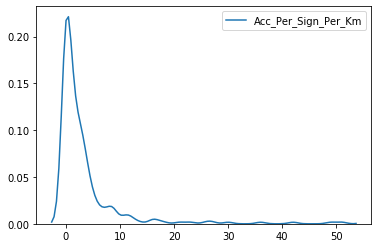

In [108]:
sns.kdeplot(gdf_pop['Acc_Per_Sign_Per_Km'])

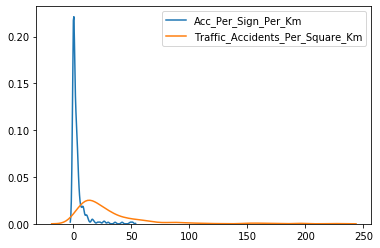

In [109]:
sns.kdeplot(gdf_pop['Acc_Per_Sign_Per_Km'])
sns.kdeplot(gdf_pop['Traffic_Accidents_Per_Square_Km'])

In [110]:
gdf_pop['Acc_Per_Sign_Per_Km'].mean()

3.370234428715515

In [111]:
gdf_pop['Acc_Per_Sign_Per_Km'].median()

1.2500000000000002